In [30]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "2"   #(xxxx is your specific GPU ID)

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torchvision.models as models
from torch.utils.data import DataLoader, TensorDataset
from torchsummary import summary
import copy
import matplotlib.pyplot as plt
import pandas as pd
import timeit

In [3]:
if torch.cuda.is_available():
    dev = "cuda:0" 
else:
    dev = "cpu" 
device = torch.device(dev) 

In [4]:
print(torch.__version__)

1.10.1+cu102


In [5]:
###################### model 2 (keyword)###################### 

class keyword_net(nn.Module):
    def __init__(self):
        super(keyword_net, self).__init__()
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.softmax = nn.Softmax(dim=1)            
        self.cvd = nn.Conv2d(in_channels=10, out_channels=3, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
        self.fc1_1 = nn.Linear(71910,128) 
        self.fc1_2 = nn.Linear(128,256) 
        self.keyword_output_1 = nn.Linear(256,27) 
        self.fc2_1 = nn.Linear(71910,512) # Dense_2_1 = tf.keras.layers.Dense(shape_2_1, activation=actv_fun_2_1,name='fc2_1')
        self.fc2_2 = nn.Linear(512,512) # tf.keras.layers.Dense(shape_2_2, activation=actv_fun_2_2,name='fc2_2')
        self.getalphafromy2 = nn.Linear(512,512)
        self.fc2_3 = nn.Linear(1024,512)
        self.keyword_output_2 = nn.Linear(512,52) # tf.keras.layers.Dense(10, activation='softmax',name='command_output')


    def forward(self, x):   
        x =  x.reshape(x.size(0), x.size(1), x.size(2), -1) 
        x = self.cvd(x)
        x = x.view(x.size(0), -1) 
        
        y1 = self.fc1_1(x)
        y1 = self.relu(y1)
        y1 = self.fc1_2(y1)
        y1 = self.sigmoid(y1) 
        y1 = self.keyword_output_1(y1)
        y1 = self.softmax(y1)
        
        y2 = self.fc2_1(x)
        y2 = self.relu(y2)
        y2 = self.fc2_2(y2)
        y2 = self.sigmoid(y2) 
        y2 = self.keyword_output_2(y2)
        y2 = self.softmax(y2)
        return y1,y2

In [6]:
class CombinedModel(nn.Module):
    def __init__(self, PRETRAIN_MODEL,keyword_net):
        super(CombinedModel, self).__init__()
        self.pretrain_model = PRETRAIN_MODEL
        self.keyword_net = keyword_net
        
    def forward(self, x):
#         print(x.shape)
#         print(x[:][0].shape)
        x1 = self.pretrain_model(x[:,0,:,:])
        x1 = torch.unsqueeze(x1, dim=1)
#         print(x1.shape)
        x2 = self.pretrain_model(x[:,1,:,:])
        x2 = torch.unsqueeze(x2, dim=1)
        x3 = self.pretrain_model(x[:,2,:,:])
        x3 = torch.unsqueeze(x3, dim=1)
        x4 = self.pretrain_model(x[:,3,:,:])
        x4 = torch.unsqueeze(x4, dim=1)        
        x5 = self.pretrain_model(x[:,4,:,:])
        x5 = torch.unsqueeze(x5, dim=1)        
        x6 = self.pretrain_model(x[:,5,:,:])
        x6 = torch.unsqueeze(x6, dim=1)        
        x7 = self.pretrain_model(x[:,6,:,:]) 
        x7 = torch.unsqueeze(x7, dim=1)    
        x8 = self.pretrain_model(x[:,7,:,:])
        x8 = torch.unsqueeze(x8, dim=1)        
        x9 = self.pretrain_model(x[:,8,:,:])
        x9 = torch.unsqueeze(x9, dim=1)        
        x10 = self.pretrain_model(x[:,9,:,:]) 
        x10 = torch.unsqueeze(x10, dim=1)    
                
        x = torch.cat((x1, x2, x3, x4, x5, x6, x7,x8,x9,x10), axis=1)
#         print(x.shape)
        y1, y2= self.keyword_net(x)
        return y1, y2
        

In [8]:
# summary(model,(10,3,224,224))

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import preprocess_input
import tensorflow as tf

In [ ]:
train_number = 27
load_Data = ImageDataGenerator(rescale=1./255)
Train_X = []
Test_X = []

for chanl in range(1,11):
    chanl = str(chanl)

    train_generator = load_Data.flow_from_directory("Nina_DB1_Scaleogram(cmor33_1-100scale_1029)/Channel_%s/Train"%chanl,
                                                    batch_size=1,
                                                    target_size=(224,224), 
                                                    class_mode='categorical',
                                                    shuffle=False)
    image_names = train_generator.filenames
    participant_no = [i.split("/")[1].split("_")[4] for i in image_names]
    train_participant_no = np.array(list(map(int, participant_no)))
    Train_command_class = tf.keras.utils.to_categorical(train_generator.classes, num_classes=52)
    Train_participant_class = tf.keras.utils.to_categorical(train_participant_no-1, num_classes=train_number)
    Train_Inputs = [next(train_generator)[0][0] for _ in range(len(train_generator))]
    Train_Inputs = np.array(Train_Inputs)



    test_generator = load_Data.flow_from_directory('Nina_DB1_Scaleogram(cmor33_1-100scale_1029)/Channel_%s/Test'%chanl,
                                                    batch_size=1,
                                                    target_size=(224,224), 
                                                    class_mode='categorical',
                                                    shuffle=False)
    image_names = test_generator.filenames
    participant_no = [i.split("/")[1].split("_")[4].split(".")[0] for i in image_names]
    test_participant_no = np.array(list(map(int, participant_no)))
    Test_participant_class = tf.keras.utils.to_categorical(test_participant_no-1, num_classes=train_number)
    Test_command_class = tf.keras.utils.to_categorical(test_generator.classes, num_classes=52)
    Test_Inputs = [next(test_generator)[0][0] for _ in range(len(test_generator))]
    Test_Inputs = np.array(Test_Inputs)
    
    Train_X.append(Train_Inputs.transpose(0,3,1,2))
    Test_X.append(Test_Inputs.transpose(0,3,1,2))    

    
Train_Y_command = Train_command_class
Train_Y_subject = Train_participant_class
Test_Y_command = Test_command_class
Test_Y_subject = Test_participant_class
Train_Y_command_uniform = Train_Y_command*0+1/52
Train_Y_subject_uniform = Train_Y_subject*0+1/train_number

Found 9828 images belonging to 52 classes.
Found 4212 images belonging to 52 classes.
Found 9828 images belonging to 52 classes.
Found 4212 images belonging to 52 classes.
Found 9828 images belonging to 52 classes.
Found 4212 images belonging to 52 classes.
Found 9828 images belonging to 52 classes.
Found 4212 images belonging to 52 classes.
Found 9828 images belonging to 52 classes.
Found 4212 images belonging to 52 classes.
Found 9828 images belonging to 52 classes.
Found 4212 images belonging to 52 classes.
Found 9828 images belonging to 52 classes.
Found 4212 images belonging to 52 classes.
Found 9828 images belonging to 52 classes.
Found 4212 images belonging to 52 classes.
Found 9828 images belonging to 52 classes.
Found 4212 images belonging to 52 classes.
Found 9828 images belonging to 52 classes.
Found 4212 images belonging to 52 classes.


In [11]:
Train_X[0].shape,Test_X[0].shape

((9828, 3, 224, 224), (4212, 3, 224, 224))

In [12]:
#((9828, 3, 224, 224), (4212, 3, 224, 224))

In [13]:
Train_Inputs = torch.from_numpy(np.array(Train_X))
Test_Inputs = torch.from_numpy(np.array(Test_X))

In [14]:
def img_to_patch(x, patch_size, flatten_channels=True):
    """
    Inputs:
        x - torch.Tensor representing the image of shape [B, C, H, W]
        patch_size - Number of pixels per dimension of the patches (integer)
        flatten_channels - If True, the patches will be returned in a flattened format
                           as a feature vector instead of a image grid.
    """
    C, H, W = x.shape
    x = x.reshape(C, H//patch_size, patch_size, W//patch_size, patch_size)
    x = x.permute(1, 3, 0, 2, 4) # [B, H', W', C, p_H, p_W]
    x = x.flatten(0,1)              # [B, H'*W', C, p_H, p_W]
    if flatten_channels:
        x = x.flatten(1,3)          # [B, H'*W', C*p_H*p_W]
    return x

In [15]:
Train_Inputs[0][0].shape

torch.Size([3, 224, 224])

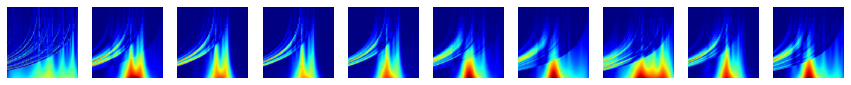

In [16]:
plt.figure(figsize=(15,3))
for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.imshow(Train_Inputs[i][0].permute(1, 2, 0))
    plt.axis("off")
plt.show()
plt.close()

In [17]:
batch = 28
dataset = TensorDataset(Train_Inputs.permute(1,0,2,3,4), torch.from_numpy(Train_participant_class), torch.from_numpy(Train_command_class))
dataloader = DataLoader(dataset, batch_size=batch, shuffle=True)

val_dataset = TensorDataset(Test_Inputs.permute(1,0,2,3,4), torch.from_numpy(Test_participant_class), torch.from_numpy(Test_command_class))
val_dataloader = DataLoader(val_dataset, batch_size=batch, shuffle=True)

In [18]:
y_test_sub = torch.from_numpy(Test_participant_class)
y_test_comd = torch.from_numpy(Test_command_class)

# freeze

In [19]:
unfreeze_bool = False
Perfomance = pd.DataFrame()
MODEL_LIST = []
LOSS_LIST = []
best_in_total = 0
for run in range(0,5):
    print(f"{run + 1} run: \n-------------------------------") 

    resnet = models.resnet18(pretrained=True)
    PRETRAIN_MODEL = torch.nn.Sequential(*(list(resnet.children())[:-2]))
    model = CombinedModel(PRETRAIN_MODEL,keyword_net())

    loss_function = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
    model.to(device)
    Train_accuracy_sub = []
    Train_accuracy_comd = []
    Val_accuracy_sub = [] 
    Val_accuracy_comd = [] 
    losses_sub = []
    losses_mov = [] 
    total_losses = []
    best_in_run = 0 
    patience = 0
    best_model = CombinedModel(PRETRAIN_MODEL,keyword_net())
    start = timeit.default_timer()
    for epoch in range(100):
        print(f"\n-------------------------------")    
        print(f"Epoch {epoch + 1} :")
        for param in model.pretrain_model.parameters():
            param.requires_grad = unfreeze_bool
        for param in model.keyword_net.parameters():
            param.requires_grad = True
#         for name, param in model.named_parameters():
#             if param.requires_grad:
#                 print(f"{name} is trainable")
#             else:
#                 print(f"{name} is frozen")
        t_acc_sub = []
        t_acc_comd = []   
        losses_sub_batch=[]
        losses_mov_batch=[]
        total_loss_batch=[]
        for id_batch, (x_batch, y_batch_sub,y_batch_comd) in enumerate(dataloader):
            x_batch = x_batch.to(device)
            y_batch_sub = y_batch_sub.to(device)
            y_batch_comd = y_batch_comd.to(device)
            pred_y = model(x_batch)
            loss_sub = loss_function(pred_y[0], y_batch_sub)
            loss_mov = loss_function(pred_y[1], y_batch_comd)
            loss = loss_sub + loss_mov
            model.zero_grad()
            loss.backward()
            optimizer.step()
    #         print(id_batch)
            total_loss_batch.append(loss.item())
            losses_sub_batch.append(loss_sub.item())
            losses_mov_batch.append(loss_mov.item())
            t_acc_sub.append((torch.sum(torch.argmax(pred_y[0], 1) == torch.argmax (y_batch_sub, 1) )/(pred_y[0].size()[0])).item())
            t_acc_comd.append((torch.sum(torch.argmax(pred_y[1], 1) == torch.argmax (y_batch_comd, 1) )/(pred_y[1].size()[0])).item())        
        losses_sub.append(sum(losses_sub_batch)/len(losses_sub_batch))
        losses_mov.append(sum(losses_mov_batch)/len(losses_mov_batch))
        total_losses.append(sum(total_loss_batch)/len(total_loss_batch))
        Train_accuracy_sub.append(sum(t_acc_sub)/len(t_acc_sub))
        Train_accuracy_comd.append(sum(t_acc_comd)/len(t_acc_comd))
        for param in model.parameters():
            param.requires_grad = False
        model.eval()
        v_sub_pred = []
        v_comd_pred = [] 
        v_sub_real = []
        v_comd_real = []
        for id_batch, (x_batch, y_batch_sub,y_batch_comd) in enumerate(val_dataloader):
            x_batch = x_batch.to(device)
            y_batch_sub = y_batch_sub.to(device)
            y_batch_comd = y_batch_comd.to(device)
            pred_y = model(x_batch)
            v_sub_real.append( torch.argmax (y_batch_sub, 1))
            v_comd_real.append( torch.argmax (y_batch_comd, 1))
            v_sub_pred.append(torch.argmax(pred_y[0], 1) )
            v_comd_pred.append(torch.argmax(pred_y[1], 1) )  

        v_sub_real = [item for sublist in v_sub_real for item in sublist.tolist()]
        v_comd_real = [item for sublist in v_comd_real for item in sublist.tolist()]
        v_sub_pred = [item for sublist in v_sub_pred for item in sublist.tolist()]
        v_comd_pred = [item for sublist in v_comd_pred for item in sublist.tolist()]
        Val_accuracy_sub.append(sum(np.array(v_sub_real) == np.array(v_sub_pred))/len(v_sub_real))
        Val_accuracy_comd.append(sum(np.array(v_comd_pred )== np.array(v_comd_real))/len(v_comd_real))
        print("loss:",loss.item(), ", subject train accuracy:",Train_accuracy_sub[-1],
              ", movement train accuracy:",Train_accuracy_comd[-1],", val subject accuracy:",Val_accuracy_sub[-1],
              ", val movement accuracy:",Val_accuracy_comd[-1])
        if Val_accuracy_comd[-1] + Val_accuracy_sub[-1] > best_in_run:
            best_in_run = Val_accuracy_comd[-1] + Val_accuracy_sub[-1]
            patience = 0
            best_state_dict_in_run = copy.deepcopy(model.state_dict())
            if best_in_run > best_in_total: 
                best_in_total = best_in_run
                best_state_dict_in_total = copy.deepcopy(model.state_dict())
        else:
            patience = patience + 1
        if patience>=10:
            break
        del x_batch, y_batch_sub,y_batch_comd 
    stop = timeit.default_timer()
    run_time = stop - start
    # Load the best model for this subject
    best_model.load_state_dict(best_state_dict_in_run)
    MODEL_LIST.append( best_state_dict_in_run)
    LOSS_LIST.append({'total': total_losses,'sub': losses_sub, 'mov': losses_mov,
                      'train_acc_sub' : Train_accuracy_sub,'train_acc_mov' : Train_accuracy_comd,
                     'val_acc_sub' : Val_accuracy_sub,'val_acc_mov' : Val_accuracy_comd,})
    for param in best_model.parameters():
        param.requires_grad = False
    best_model.to(device)
    best_model.eval()
    pred_y_sub = []
    pred_y_comd = []
    for i in range(Test_Inputs.shape[1]):
        pred_y_sub.append(best_model(Test_Inputs.permute(1,0,2,3,4)[i].view(-1,10,3,224,224).to(device))[0].cpu()[0].detach().numpy())
        pred_y_comd.append(best_model(Test_Inputs.permute(1,0,2,3,4)[i].view(-1,10,3,224,224).to(device))[1].cpu()[0].detach().numpy())
    sub_acc = np.sum(np.argmax (pred_y_sub, 1) == torch.argmax (y_test_sub, 1).numpy() )/(len(pred_y_sub))
    comd_acc = np.sum(np.argmax (pred_y_comd, 1) == torch.argmax (y_test_comd, 1).numpy() )/(len(pred_y_comd))

    acc_on_subjects=[]
    for s in range(1,28):
        tensordata = Test_Inputs.permute(1,0,2,3,4)[test_participant_no==s]
        x_test = tensordata.to(device)
        y_test_comd_s = torch.from_numpy(Test_command_class[test_participant_no==s])
        pred_y_comd = []
        for i in range(len(x_test)):
            pred_y_comd.append(best_model(x_test[i].view(-1,10,3,224,224))[1].cpu()[0].detach().numpy())
        comd_acc_s = np.sum(np.argmax (pred_y_comd, 1) == torch.argmax (y_test_comd_s.cpu(), 1).numpy() )/(len(pred_y_comd))
        acc_on_subjects.append(comd_acc_s.item()) 

    
    Perfomance = Perfomance.append({'Run': run+1,'Training Time':run_time,'Movement Accuracy':comd_acc.item(),'Subject Accuracy':sub_acc.item(),
                                   'Sub_1':acc_on_subjects[0],'Sub_2':acc_on_subjects[1],'Sub_3':acc_on_subjects[2],
                                    'Sub_4':acc_on_subjects[3],'Sub_5':acc_on_subjects[4],'Sub_6':acc_on_subjects[5],
                                    'Sub_7':acc_on_subjects[6],'Sub_8':acc_on_subjects[7],'Sub_9':acc_on_subjects[8],
                                    'Sub_10':acc_on_subjects[9],'Sub_11':acc_on_subjects[10],'Sub_12':acc_on_subjects[11],
                                    'Sub_13':acc_on_subjects[12], 'Sub_14':acc_on_subjects[13],'Sub_15':acc_on_subjects[14],
                                    'Sub_16':acc_on_subjects[15],'Sub_17':acc_on_subjects[16],'Sub_18':acc_on_subjects[17],
                                    'Sub_19':acc_on_subjects[18],'Sub_20':acc_on_subjects[19],'Sub_21':acc_on_subjects[20],
                                    'Sub_22':acc_on_subjects[21],'Sub_23':acc_on_subjects[22],'Sub_24':acc_on_subjects[23],
                                    'Sub_25':acc_on_subjects[24],'Sub_26':acc_on_subjects[25],'Sub_27':acc_on_subjects[26]}, ignore_index=True)
    print('\nRun ', run+1,'Movement Accuracy is :',comd_acc.item(),'Subject Accuracy',sub_acc.item(),'Sub_1:',acc_on_subjects[0],
                                    'Sub_2:',acc_on_subjects[1],'Sub_3:',acc_on_subjects[2],
                                    'Sub_4:',acc_on_subjects[3],'Sub_5:',acc_on_subjects[4],'Sub_6:',acc_on_subjects[5],
                                    'Sub_7:',acc_on_subjects[6],'Sub_8:',acc_on_subjects[7],'Sub_9:',acc_on_subjects[8],
                                    'Sub_10:',acc_on_subjects[9],'Sub_11:',acc_on_subjects[10],'Sub_12:',acc_on_subjects[11],
                                    'Sub_13:',acc_on_subjects[12], 'Sub_14:',acc_on_subjects[13],'Sub_15:',acc_on_subjects[14],
                                    'Sub_16:',acc_on_subjects[15],'Sub_17:',acc_on_subjects[16],'Sub_18:',acc_on_subjects[17],
                                    'Sub_19:',acc_on_subjects[18],'Sub_20:',acc_on_subjects[19],'Sub_21:',acc_on_subjects[20],
                                    'Sub_22:',acc_on_subjects[21],'Sub_23:',acc_on_subjects[22],'Sub_24:',acc_on_subjects[23],
                                    'Sub_25:',acc_on_subjects[24],'Sub_26:',acc_on_subjects[25],'Sub_27:',acc_on_subjects[26])

    # # Load the state dictionary into the new model
    del model,best_model
    torch.cuda.empty_cache()
best_index = (Perfomance['Movement Accuracy'] + Perfomance['Subject Accuracy']).idxmax()

best_model = CombinedModel(PRETRAIN_MODEL,keyword_net())
best_model.load_state_dict(MODEL_LIST[best_index])
best_loss_record = LOSS_LIST[best_index]

1 run: 
-------------------------------

-------------------------------
Epoch 1 :
loss: 6.966238021850586 , subject train accuracy: 0.24389500498899028 , movement train accuracy: 0.11650387177567537 , val subject accuracy: 0.3950617283950617 , val movement accuracy: 0.19943019943019943

-------------------------------
Epoch 2 :
loss: 6.632923126220703 , subject train accuracy: 0.5047822770399925 , movement train accuracy: 0.2546805166705721 , val subject accuracy: 0.5382241215574549 , val movement accuracy: 0.27113010446343777

-------------------------------
Epoch 3 :
loss: 6.4046196937561035 , subject train accuracy: 0.5709198472167012 , movement train accuracy: 0.33109484748792783 , val subject accuracy: 0.5591168091168092 , val movement accuracy: 0.32811016144349475

-------------------------------
Epoch 4 :
loss: 6.534516334533691 , subject train accuracy: 0.6179283977064312 , movement train accuracy: 0.3965201657212358 , val subject accuracy: 0.6149097815764483 , val movement ac

loss: 5.341719627380371 , subject train accuracy: 0.9998982499467681 , movement train accuracy: 0.9981684990418263 , val subject accuracy: 0.8786799620132953 , val movement accuracy: 0.6384140550807218

-------------------------------
Epoch 36 :
loss: 5.34157133102417 , subject train accuracy: 0.9998982499467681 , movement train accuracy: 0.9981684990418263 , val subject accuracy: 0.8796296296296297 , val movement accuracy: 0.637701804368471

-------------------------------
Epoch 37 :
loss: 5.341456890106201 , subject train accuracy: 0.9998982499467681 , movement train accuracy: 0.9982702490950581 , val subject accuracy: 0.8784425451092118 , val movement accuracy: 0.6339031339031339

-------------------------------
Epoch 38 :
loss: 5.341418266296387 , subject train accuracy: 0.9998982499467681 , movement train accuracy: 0.9984737492015219 , val subject accuracy: 0.8786799620132953 , val movement accuracy: 0.636039886039886

-------------------------------
Epoch 39 :
loss: 5.34138488769

loss: 6.054360389709473 , subject train accuracy: 0.8479853927919329 , movement train accuracy: 0.5738705999491222 , val subject accuracy: 0.7701804368471035 , val movement accuracy: 0.4392212725546059

-------------------------------
Epoch 10 :
loss: 5.910738945007324 , subject train accuracy: 0.8827839232238269 , movement train accuracy: 0.6267806561584146 , val subject accuracy: 0.7977207977207977 , val movement accuracy: 0.47435897435897434

-------------------------------
Epoch 11 :
loss: 5.824698448181152 , subject train accuracy: 0.9307082117113292 , movement train accuracy: 0.6786732133637127 , val subject accuracy: 0.8050807217473884 , val movement accuracy: 0.48717948717948717

-------------------------------
Epoch 12 :
loss: 5.641606330871582 , subject train accuracy: 0.9575702272928678 , movement train accuracy: 0.7192715063393965 , val subject accuracy: 0.8100664767331434 , val movement accuracy: 0.5208926875593543

-------------------------------
Epoch 13 :
loss: 5.711058

loss: 5.341501712799072 , subject train accuracy: 0.9997964998935363 , movement train accuracy: 0.9984737492015219 , val subject accuracy: 0.8720322886989553 , val movement accuracy: 0.6310541310541311

-------------------------------
Epoch 44 :
loss: 5.341337203979492 , subject train accuracy: 0.9997964998935363 , movement train accuracy: 0.9987789993612175 , val subject accuracy: 0.8715574548907882 , val movement accuracy: 0.6379392212725546

-------------------------------
Epoch 45 :
loss: 5.341387748718262 , subject train accuracy: 0.9997964998935363 , movement train accuracy: 0.9987789993612175 , val subject accuracy: 0.872269705603039 , val movement accuracy: 0.6350902184235517

-------------------------------
Epoch 46 :
loss: 5.341330528259277 , subject train accuracy: 0.9997964998935363 , movement train accuracy: 0.9988807494144494 , val subject accuracy: 0.8727445394112061 , val movement accuracy: 0.6429249762583096

-------------------------------
Epoch 47 :
loss: 5.341334819

loss: 5.3457136154174805 , subject train accuracy: 0.9994912497338406 , movement train accuracy: 0.9755799872243506 , val subject accuracy: 0.8641975308641975 , val movement accuracy: 0.5491452991452992

-------------------------------
Epoch 26 :
loss: 5.342763423919678 , subject train accuracy: 0.9994912497338406 , movement train accuracy: 0.9777167381724061 , val subject accuracy: 0.8632478632478633 , val movement accuracy: 0.5643399810066477

-------------------------------
Epoch 27 :
loss: 5.361486911773682 , subject train accuracy: 0.9995929997870725 , movement train accuracy: 0.9807692399391761 , val subject accuracy: 0.8663342830009497 , val movement accuracy: 0.5429724596391263

-------------------------------
Epoch 28 :
loss: 5.379454612731934 , subject train accuracy: 0.9995929997870725 , movement train accuracy: 0.9954212476045657 , val subject accuracy: 0.8672839506172839 , val movement accuracy: 0.5693257359924027

-------------------------------
Epoch 29 :
loss: 5.3790664

loss: 6.869911193847656 , subject train accuracy: 0.2755392890986045 , movement train accuracy: 0.1198616255913195 , val subject accuracy: 0.443019943019943 , val movement accuracy: 0.21462488129154797

-------------------------------
Epoch 2 :
loss: 6.39215612411499 , subject train accuracy: 0.5010175231175545 , movement train accuracy: 0.27055353238287133 , val subject accuracy: 0.5137701804368471 , val movement accuracy: 0.298670465337132

-------------------------------
Epoch 3 :
loss: 6.53121280670166 , subject train accuracy: 0.5475173220675216 , movement train accuracy: 0.3623321292407153 , val subject accuracy: 0.5538936372269706 , val movement accuracy: 0.347340930674264

-------------------------------
Epoch 4 :
loss: 6.447598457336426 , subject train accuracy: 0.5898453665424955 , movement train accuracy: 0.407000427359869 , val subject accuracy: 0.5866571699905033 , val movement accuracy: 0.3708452041785375

-------------------------------
Epoch 5 :
loss: 6.3844099044799805

loss: 5.34149169921875 , subject train accuracy: 1.0 , movement train accuracy: 0.9985754992547538 , val subject accuracy: 0.8739316239316239 , val movement accuracy: 0.6258309591642925

-------------------------------
Epoch 36 :
loss: 5.341392993927002 , subject train accuracy: 1.0 , movement train accuracy: 0.9985754992547538 , val subject accuracy: 0.8708452041785375 , val movement accuracy: 0.6274928774928775

-------------------------------
Epoch 37 :
loss: 5.3414506912231445 , subject train accuracy: 1.0 , movement train accuracy: 0.9985754992547538 , val subject accuracy: 0.8739316239316239 , val movement accuracy: 0.6308167141500475

-------------------------------
Epoch 38 :
loss: 5.341434955596924 , subject train accuracy: 1.0 , movement train accuracy: 0.9986772493079856 , val subject accuracy: 0.8734567901234568 , val movement accuracy: 0.6339031339031339

-------------------------------
Epoch 39 :
loss: 5.341383934020996 , subject train accuracy: 1.0 , movement train accur

loss: 6.093920707702637 , subject train accuracy: 0.8520553957702767 , movement train accuracy: 0.5768213537853328 , val subject accuracy: 0.7825261158594492 , val movement accuracy: 0.4560778727445394

-------------------------------
Epoch 9 :
loss: 6.044049263000488 , subject train accuracy: 0.884615424691442 , movement train accuracy: 0.61111113963983 , val subject accuracy: 0.7915479582146249 , val movement accuracy: 0.46391263057929727

-------------------------------
Epoch 10 :
loss: 5.595569610595703 , subject train accuracy: 0.9054741952833627 , movement train accuracy: 0.6488604301910454 , val subject accuracy: 0.8145773979107312 , val movement accuracy: 0.47768281101614435

-------------------------------
Epoch 11 :
loss: 5.640414237976074 , subject train accuracy: 0.923687457189261 , movement train accuracy: 0.6910867267354601 , val subject accuracy: 0.8133903133903134 , val movement accuracy: 0.5002374169040835

-------------------------------
Epoch 12 :
loss: 5.89876651763

loss: 5.341354846954346 , subject train accuracy: 0.9998982499467681 , movement train accuracy: 0.9990842495209131 , val subject accuracy: 0.8744064577397911 , val movement accuracy: 0.6495726495726496

-------------------------------
Epoch 43 :
loss: 5.341342926025391 , subject train accuracy: 0.9998982499467681 , movement train accuracy: 0.9990842495209131 , val subject accuracy: 0.8748812915479582 , val movement accuracy: 0.6502849002849003

-------------------------------
Epoch 44 :
loss: 5.34133768081665 , subject train accuracy: 0.9998982499467681 , movement train accuracy: 0.9990842495209131 , val subject accuracy: 0.8741690408357075 , val movement accuracy: 0.6474358974358975

-------------------------------
Epoch 45 :
loss: 5.341403961181641 , subject train accuracy: 0.9998982499467681 , movement train accuracy: 0.9993894996806088 , val subject accuracy: 0.8734567901234568 , val movement accuracy: 0.6514719848053181

-------------------------------
Epoch 46 :
loss: 5.341323852

In [ ]:
PATH = "Final_model/NinaProDB1_group_Featurefuse_freeze_0412"
torch.save(MODEL_LIST[(Perfomance['Movement Accuracy'] + Perfomance['Subject Accuracy']).idxmax()], PATH)

In [21]:
Perfomance.to_csv("Performance_Final_Code_NinaPro_scale33&ResNet18_Feature_Fusion_group_twotask_freeze_0412.csv",index=False)

In [22]:
Perfomance

,Movement Accuracy,Run,Sub_1,Sub_10,Sub_11,Sub_12,Sub_13,Sub_14,Sub_15,Sub_16,...,Sub_27,Sub_3,Sub_4,Sub_5,Sub_6,Sub_7,Sub_8,Sub_9,Subject Accuracy,Training Time
0,0.654796,1.0,0.621795,0.538462,0.698718,0.769231,0.634615,0.685897,0.641026,0.673077,...,0.538462,0.589744,0.583333,0.551282,0.608974,0.679487,0.807692,0.621795,0.879867,3806.183117
1,0.648386,2.0,0.647436,0.525641,0.685897,0.724359,0.660256,0.685897,0.641026,0.666667,...,0.544872,0.564103,0.551282,0.589744,0.615385,0.660256,0.814103,0.583333,0.869421,3257.769040
2,0.638414,3.0,0.647436,0.583333,0.698718,0.717949,0.602564,0.653846,0.615385,0.698718,...,0.557692,0.576923,0.487179,0.512821,0.621795,0.673077,0.814103,0.621795,0.866097,3671.361573
3,0.649335,4.0,0.628205,0.551282,0.660256,0.782051,0.641026,0.660256,0.615385,0.666667,...,0.551282,0.653846,0.557692,0.544872,0.615385,0.660256,0.788462,0.570513,0.877730,4015.802734
4,0.664292,5.0,0.673077,0.596154,0.653846,0.756410,0.621795,0.756410,0.698718,0.673077,...,0.564103,0.525641,0.512821,0.608974,0.621795,0.698718,0.794872,0.615385,0.877968,4913.571053


In [23]:
Perfomance.describe()

,Movement Accuracy,Run,Sub_1,Sub_10,Sub_11,Sub_12,Sub_13,Sub_14,Sub_15,Sub_16,...,Sub_27,Sub_3,Sub_4,Sub_5,Sub_6,Sub_7,Sub_8,Sub_9,Subject Accuracy,Training Time
count,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
mean,0.651045,3.000000,0.643590,0.558974,0.679487,0.750000,0.632051,0.688462,0.642308,0.675641,...,0.551282,0.582051,0.538462,0.561538,0.616667,0.674359,0.803846,0.602564,0.874217,3932.937503
std,0.009475,1.581139,0.020067,0.029861,0.021260,0.027942,0.021548,0.040694,0.034041,0.013293,...,0.010136,0.046755,0.038194,0.038086,0.005363,0.015961,0.011645,0.023985,0.006068,614.176257
min,0.638414,1.000000,0.621795,0.525641,0.653846,0.717949,0.602564,0.653846,0.615385,0.666667,...,0.538462,0.525641,0.487179,0.512821,0.608974,0.660256,0.788462,0.570513,0.866097,3257.769040
25%,0.648386,2.000000,0.628205,0.538462,0.660256,0.724359,0.621795,0.660256,0.615385,0.666667,...,0.544872,0.564103,0.512821,0.544872,0.615385,0.660256,0.794872,0.583333,0.869421,3671.361573
50%,0.649335,3.000000,0.647436,0.551282,0.685897,0.756410,0.634615,0.685897,0.641026,0.673077,...,0.551282,0.576923,0.551282,0.551282,0.615385,0.673077,0.807692,0.615385,0.877730,3806.183117
75%,0.654796,4.000000,0.647436,0.583333,0.698718,0.769231,0.641026,0.685897,0.641026,0.673077,...,0.557692,0.589744,0.557692,0.589744,0.621795,0.679487,0.814103,0.621795,0.877968,4015.802734
max,0.664292,5.000000,0.673077,0.596154,0.698718,0.782051,0.660256,0.756410,0.698718,0.698718,...,0.564103,0.653846,0.583333,0.608974,0.621795,0.698718,0.814103,0.621795,0.879867,4913.571053


In [24]:
se_command = Perfomance['Movement Accuracy'].std() / np.sqrt(len(Perfomance))
se_subject = Perfomance['Subject Accuracy'].std() / np.sqrt(len(Perfomance))
se_time_hour = Perfomance['Training Time'].std()/60/60 / np.sqrt(len(Perfomance))
se_command,se_subject,se_time_hour

(0.004237343049862448, 0.0027136243233104583, 0.07629665897913789)

In [25]:

pred_y_sub = []
pred_y_comd = []
best_model.to(device)
for i in range(Test_Inputs.shape[1]):
    pred_y_sub.append(best_model(Test_Inputs.permute(1,0,2,3,4)[i].view(-1,10,3,224,224).to(device))[0].cpu()[0].detach().numpy())
    pred_y_comd.append(best_model(Test_Inputs.permute(1,0,2,3,4)[i].view(-1,10,3,224,224).to(device))[1].cpu()[0].detach().numpy())
sub_acc = np.sum(np.argmax (pred_y_sub, 1) == torch.argmax (y_test_sub, 1).numpy() )/(len(pred_y_sub))
comd_acc = np.sum(np.argmax (pred_y_comd, 1) == torch.argmax (y_test_comd, 1).numpy() )/(len(pred_y_comd))
print("Test Subject Accuracy:",sub_acc.item())
print("Test Command Accuracy:",comd_acc.item())

Test Subject Accuracy: 0.8779677113010447
Test Command Accuracy: 0.664292497625831


<AxesSubplot:>

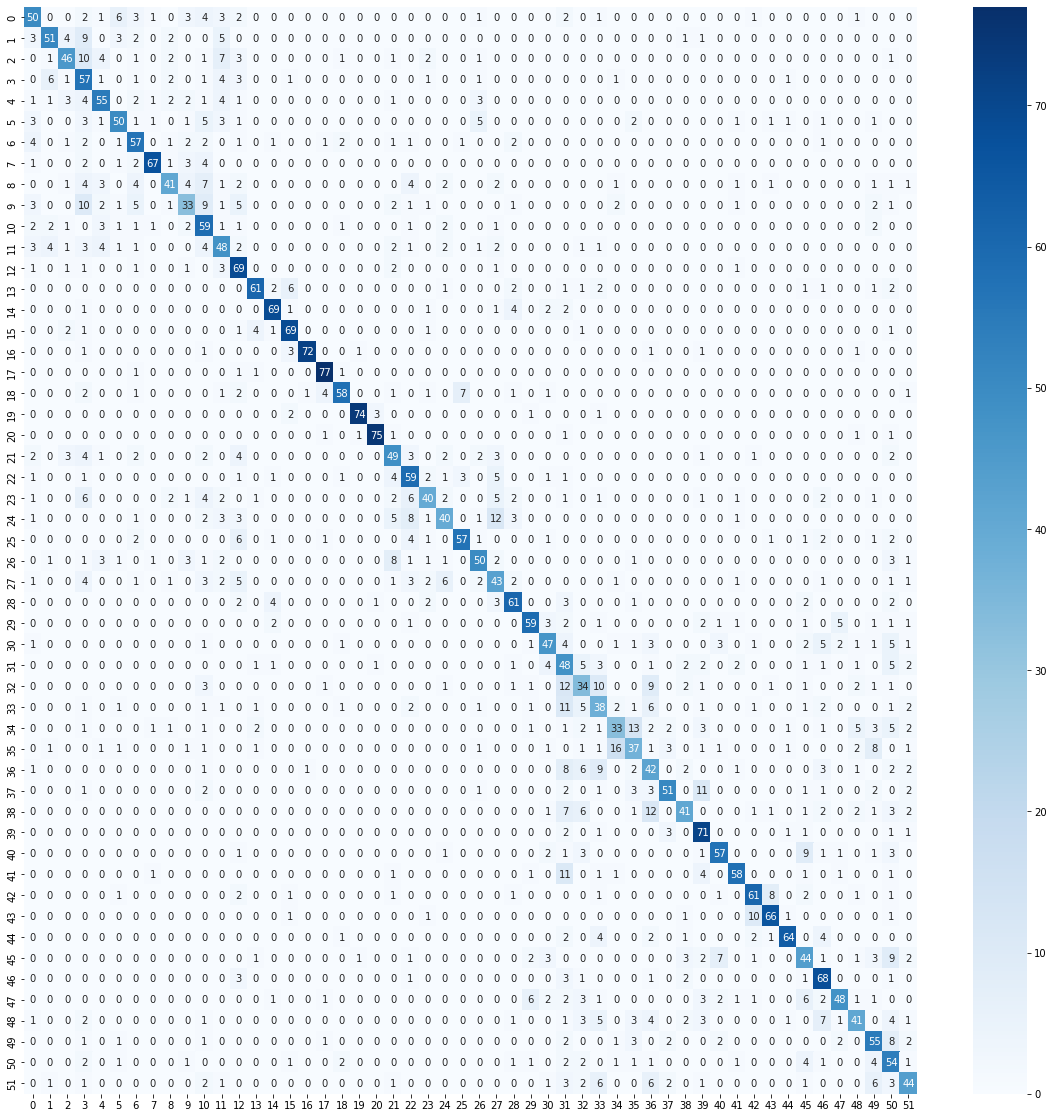

In [26]:
import seaborn as sns
import sklearn.metrics
plt.figure(figsize=(20,20))
sns.heatmap(sklearn.metrics.confusion_matrix(torch.argmax (y_test_comd.cpu(), 1).numpy() , np.argmax (pred_y_comd, 1)), annot=True,cmap='Blues')

In [27]:
for s in range(1,28):
    tensordata = Test_Inputs.permute(1,0,2,3,4)[test_participant_no==s]
    x_test_single = tensordata.to(device)
    y_test_comd_single = torch.from_numpy(Test_command_class[test_participant_no==s])
    pred_y_sub_single = []
    pred_y_comd_single = []
    for i in range(len(x_test_single)):
        pred_y_comd_single.append(best_model(x_test_single[i].view(-1,10,3,224,224))[1].cpu()[0].detach().numpy())
    comd_acc_single = np.sum(np.argmax (pred_y_comd_single, 1) == torch.argmax (y_test_comd_single.cpu(), 1).numpy() )/(len(pred_y_comd_single))
    print("Subject #",s,": test Command Accuracy:",np.round(comd_acc_single.item(),4))


Subject # 1 : test Command Accuracy: 0.6731
Subject # 2 : test Command Accuracy: 0.4679
Subject # 3 : test Command Accuracy: 0.5256
Subject # 4 : test Command Accuracy: 0.5128
Subject # 5 : test Command Accuracy: 0.609
Subject # 6 : test Command Accuracy: 0.6218
Subject # 7 : test Command Accuracy: 0.6987
Subject # 8 : test Command Accuracy: 0.7949
Subject # 9 : test Command Accuracy: 0.6154
Subject # 10 : test Command Accuracy: 0.5962
Subject # 11 : test Command Accuracy: 0.6538
Subject # 12 : test Command Accuracy: 0.7564
Subject # 13 : test Command Accuracy: 0.6218
Subject # 14 : test Command Accuracy: 0.7564
Subject # 15 : test Command Accuracy: 0.6987
Subject # 16 : test Command Accuracy: 0.6731
Subject # 17 : test Command Accuracy: 0.7436
Subject # 18 : test Command Accuracy: 0.5769
Subject # 19 : test Command Accuracy: 0.7308
Subject # 20 : test Command Accuracy: 0.6859
Subject # 21 : test Command Accuracy: 0.8974
Subject # 22 : test Command Accuracy: 0.7692
Subject # 23 : test 

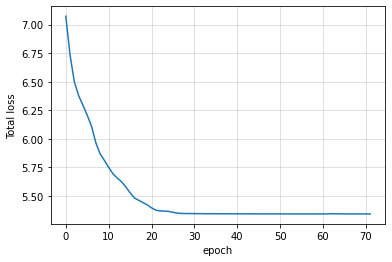

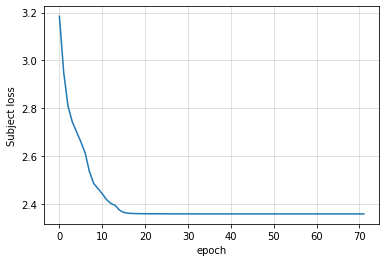

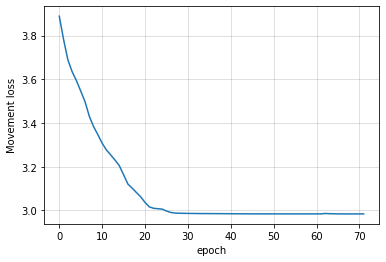

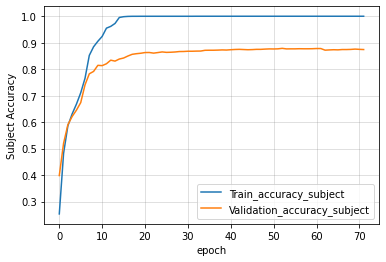

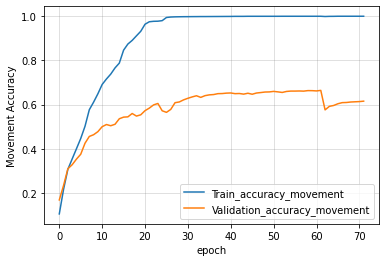

In [28]:
import matplotlib.pyplot as plt
plt.plot(best_loss_record['total'])
plt.ylabel('Total loss')
plt.xlabel('epoch')
plt.grid(color='gray', alpha=0.3)
plt.show()

plt.plot(best_loss_record['sub'])
plt.ylabel('Subject loss')
plt.xlabel('epoch')
plt.grid(color='gray', alpha=0.3)
plt.show()

plt.plot(best_loss_record['mov'])
plt.ylabel('Movement loss')
plt.grid(color='gray', alpha=0.3)
plt.xlabel('epoch')
plt.show()


plt.plot(best_loss_record['train_acc_sub'],label="Train_accuracy_subject")
plt.plot(best_loss_record['val_acc_sub'],label="Validation_accuracy_subject")
plt.ylabel('Subject Accuracy')
plt.xlabel('epoch')
plt.legend()
plt.grid(color='gray', alpha=0.3)
plt.show()

plt.plot(best_loss_record['train_acc_mov'],label="Train_accuracy_movement")
plt.plot(best_loss_record['val_acc_mov'],label="Validation_accuracy_movement")
plt.ylabel('Movement Accuracy')
plt.xlabel('epoch')
plt.legend()
plt.grid(color='gray', alpha=0.3)
plt.show()

# unfreeze

In [32]:
unfreeze_bool = True
Perfomance = pd.DataFrame()
MODEL_LIST = []
LOSS_LIST = []
best_in_total = 0
for run in range(0,5):
    print(f"{run + 1} run: \n-------------------------------") 

    resnet = models.resnet18(pretrained=True)
    PRETRAIN_MODEL = torch.nn.Sequential(*(list(resnet.children())[:-2]))
    model = CombinedModel(PRETRAIN_MODEL,keyword_net())

    loss_function = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
    model.to(device)
    Train_accuracy_sub = []
    Train_accuracy_comd = []
    Val_accuracy_sub = [] 
    Val_accuracy_comd = [] 
    losses_sub = []
    losses_mov = [] 
    total_losses = []
    best_in_run = 0 
    patience = 0
    best_model = CombinedModel(PRETRAIN_MODEL,keyword_net())
    start = timeit.default_timer()
    for epoch in range(100):
        print(f"\n-------------------------------")    
        print(f"Epoch {epoch + 1} :")
        for param in model.pretrain_model.parameters():
            param.requires_grad = unfreeze_bool
        for param in model.keyword_net.parameters():
            param.requires_grad = True
#         for name, param in model.named_parameters():
#             if param.requires_grad:
#                 print(f"{name} is trainable")
#             else:
#                 print(f"{name} is frozen")
        t_acc_sub = []
        t_acc_comd = []   
        losses_sub_batch=[]
        losses_mov_batch=[]
        total_loss_batch=[]
        for id_batch, (x_batch, y_batch_sub,y_batch_comd) in enumerate(dataloader):
            x_batch = x_batch.to(device)
            y_batch_sub = y_batch_sub.to(device)
            y_batch_comd = y_batch_comd.to(device)
            pred_y = model(x_batch)
            loss_sub = loss_function(pred_y[0], y_batch_sub)
            loss_mov = loss_function(pred_y[1], y_batch_comd)
            loss = loss_sub + loss_mov
            model.zero_grad()
            loss.backward()
            optimizer.step()
    #         print(id_batch)
            total_loss_batch.append(loss.item())
            losses_sub_batch.append(loss_sub.item())
            losses_mov_batch.append(loss_mov.item())
            t_acc_sub.append((torch.sum(torch.argmax(pred_y[0], 1) == torch.argmax (y_batch_sub, 1) )/(pred_y[0].size()[0])).item())
            t_acc_comd.append((torch.sum(torch.argmax(pred_y[1], 1) == torch.argmax (y_batch_comd, 1) )/(pred_y[1].size()[0])).item())        
        losses_sub.append(sum(losses_sub_batch)/len(losses_sub_batch))
        losses_mov.append(sum(losses_mov_batch)/len(losses_mov_batch))
        total_losses.append(sum(total_loss_batch)/len(total_loss_batch))
        Train_accuracy_sub.append(sum(t_acc_sub)/len(t_acc_sub))
        Train_accuracy_comd.append(sum(t_acc_comd)/len(t_acc_comd))
        for param in model.parameters():
            param.requires_grad = False
        model.eval()
        v_sub_pred = []
        v_comd_pred = [] 
        v_sub_real = []
        v_comd_real = []
        for id_batch, (x_batch, y_batch_sub,y_batch_comd) in enumerate(val_dataloader):
            x_batch = x_batch.to(device)
            y_batch_sub = y_batch_sub.to(device)
            y_batch_comd = y_batch_comd.to(device)
            pred_y = model(x_batch)
            v_sub_real.append( torch.argmax (y_batch_sub, 1))
            v_comd_real.append( torch.argmax (y_batch_comd, 1))
            v_sub_pred.append(torch.argmax(pred_y[0], 1) )
            v_comd_pred.append(torch.argmax(pred_y[1], 1) )  

        v_sub_real = [item for sublist in v_sub_real for item in sublist.tolist()]
        v_comd_real = [item for sublist in v_comd_real for item in sublist.tolist()]
        v_sub_pred = [item for sublist in v_sub_pred for item in sublist.tolist()]
        v_comd_pred = [item for sublist in v_comd_pred for item in sublist.tolist()]
        Val_accuracy_sub.append(sum(np.array(v_sub_real) == np.array(v_sub_pred))/len(v_sub_real))
        Val_accuracy_comd.append(sum(np.array(v_comd_pred )== np.array(v_comd_real))/len(v_comd_real))
        print("loss:",loss.item(), ", subject train accuracy:",Train_accuracy_sub[-1],
              ", movement train accuracy:",Train_accuracy_comd[-1],", val subject accuracy:",Val_accuracy_sub[-1],
              ", val movement accuracy:",Val_accuracy_comd[-1])
        if Val_accuracy_comd[-1] + Val_accuracy_sub[-1] > best_in_run:
            best_in_run = Val_accuracy_comd[-1] + Val_accuracy_sub[-1]
            patience = 0
            best_state_dict_in_run = copy.deepcopy(model.state_dict())
            if best_in_run > best_in_total: 
                best_in_total = best_in_run
                best_state_dict_in_total = copy.deepcopy(model.state_dict())
        else:
            patience = patience + 1
        if patience>=10:
            break
        del x_batch, y_batch_sub,y_batch_comd 
    stop = timeit.default_timer()
    run_time = stop - start
    # Load the best model for this subject
    best_model.load_state_dict(best_state_dict_in_run)
    MODEL_LIST.append( best_state_dict_in_run)
    LOSS_LIST.append({'total': total_losses,'sub': losses_sub, 'mov': losses_mov,
                      'train_acc_sub' : Train_accuracy_sub,'train_acc_mov' : Train_accuracy_comd,
                     'val_acc_sub' : Val_accuracy_sub,'val_acc_mov' : Val_accuracy_comd,})
    for param in best_model.parameters():
        param.requires_grad = False
    best_model.to(device)
    best_model.eval()
    pred_y_sub = []
    pred_y_comd = []
    for i in range(Test_Inputs.shape[1]):
        pred_y_sub.append(best_model(Test_Inputs.permute(1,0,2,3,4)[i].view(-1,10,3,224,224).to(device))[0].cpu()[0].detach().numpy())
        pred_y_comd.append(best_model(Test_Inputs.permute(1,0,2,3,4)[i].view(-1,10,3,224,224).to(device))[1].cpu()[0].detach().numpy())
    sub_acc = np.sum(np.argmax (pred_y_sub, 1) == torch.argmax (y_test_sub, 1).numpy() )/(len(pred_y_sub))
    comd_acc = np.sum(np.argmax (pred_y_comd, 1) == torch.argmax (y_test_comd, 1).numpy() )/(len(pred_y_comd))

    acc_on_subjects=[]
    for s in range(1,28):
        tensordata = Test_Inputs.permute(1,0,2,3,4)[test_participant_no==s]
        x_test = tensordata.to(device)
        y_test_comd_s = torch.from_numpy(Test_command_class[test_participant_no==s])
        pred_y_comd = []
        for i in range(len(x_test)):
            pred_y_comd.append(best_model(x_test[i].view(-1,10,3,224,224))[1].cpu()[0].detach().numpy())
        comd_acc_s = np.sum(np.argmax (pred_y_comd, 1) == torch.argmax (y_test_comd_s.cpu(), 1).numpy() )/(len(pred_y_comd))
        acc_on_subjects.append(comd_acc_s.item()) 

    
    Perfomance = Perfomance.append({'Run': run+1,'Training Time':run_time,'Movement Accuracy':comd_acc.item(),'Subject Accuracy':sub_acc.item(),
                                   'Sub_1':acc_on_subjects[0],'Sub_2':acc_on_subjects[1],'Sub_3':acc_on_subjects[2],
                                    'Sub_4':acc_on_subjects[3],'Sub_5':acc_on_subjects[4],'Sub_6':acc_on_subjects[5],
                                    'Sub_7':acc_on_subjects[6],'Sub_8':acc_on_subjects[7],'Sub_9':acc_on_subjects[8],
                                    'Sub_10':acc_on_subjects[9],'Sub_11':acc_on_subjects[10],'Sub_12':acc_on_subjects[11],
                                    'Sub_13':acc_on_subjects[12], 'Sub_14':acc_on_subjects[13],'Sub_15':acc_on_subjects[14],
                                    'Sub_16':acc_on_subjects[15],'Sub_17':acc_on_subjects[16],'Sub_18':acc_on_subjects[17],
                                    'Sub_19':acc_on_subjects[18],'Sub_20':acc_on_subjects[19],'Sub_21':acc_on_subjects[20],
                                    'Sub_22':acc_on_subjects[21],'Sub_23':acc_on_subjects[22],'Sub_24':acc_on_subjects[23],
                                    'Sub_25':acc_on_subjects[24],'Sub_26':acc_on_subjects[25],'Sub_27':acc_on_subjects[26]}, ignore_index=True)
    print('\nRun ', run+1,'Movement Accuracy is :',comd_acc.item(),'Subject Accuracy',sub_acc.item(),'Sub_1:',acc_on_subjects[0],
                                    'Sub_2:',acc_on_subjects[1],'Sub_3:',acc_on_subjects[2],
                                    'Sub_4:',acc_on_subjects[3],'Sub_5:',acc_on_subjects[4],'Sub_6:',acc_on_subjects[5],
                                    'Sub_7:',acc_on_subjects[6],'Sub_8:',acc_on_subjects[7],'Sub_9:',acc_on_subjects[8],
                                    'Sub_10:',acc_on_subjects[9],'Sub_11:',acc_on_subjects[10],'Sub_12:',acc_on_subjects[11],
                                    'Sub_13:',acc_on_subjects[12], 'Sub_14:',acc_on_subjects[13],'Sub_15:',acc_on_subjects[14],
                                    'Sub_16:',acc_on_subjects[15],'Sub_17:',acc_on_subjects[16],'Sub_18:',acc_on_subjects[17],
                                    'Sub_19:',acc_on_subjects[18],'Sub_20:',acc_on_subjects[19],'Sub_21:',acc_on_subjects[20],
                                    'Sub_22:',acc_on_subjects[21],'Sub_23:',acc_on_subjects[22],'Sub_24:',acc_on_subjects[23],
                                    'Sub_25:',acc_on_subjects[24],'Sub_26:',acc_on_subjects[25],'Sub_27:',acc_on_subjects[26])

    # # Load the state dictionary into the new model
    del model,best_model
    torch.cuda.empty_cache()
best_index = (Perfomance['Movement Accuracy'] + Perfomance['Subject Accuracy']).idxmax()

best_model = CombinedModel(PRETRAIN_MODEL,keyword_net())
best_model.load_state_dict(MODEL_LIST[best_index])
best_loss_record = LOSS_LIST[best_index]

1 run: 
-------------------------------

-------------------------------
Epoch 1 :
loss: 6.957393646240234 , subject train accuracy: 0.3099308242846249 , movement train accuracy: 0.1377696442680481 , val subject accuracy: 0.4470560303893637 , val movement accuracy: 0.21581196581196582

-------------------------------
Epoch 2 :
loss: 6.559880256652832 , subject train accuracy: 0.48178675371697144 , movement train accuracy: 0.23260074352946378 , val subject accuracy: 0.5332383665716999 , val movement accuracy: 0.24620132953466287

-------------------------------
Epoch 3 :
loss: 6.533962249755859 , subject train accuracy: 0.550773325893614 , movement train accuracy: 0.26088727252860355 , val subject accuracy: 0.5752611585944919 , val movement accuracy: 0.26661918328584994

-------------------------------
Epoch 4 :
loss: 6.485107421875 , subject train accuracy: 0.6318681628106326 , movement train accuracy: 0.2737077863255457 , val subject accuracy: 0.6524216524216524 , val movement accurac

loss: 5.476043701171875 , subject train accuracy: 0.9966422482433482 , movement train accuracy: 0.9433252189913367 , val subject accuracy: 0.9375593542260209 , val movement accuracy: 0.8093542260208927

-------------------------------
Epoch 36 :
loss: 5.4561004638671875 , subject train accuracy: 0.9986772493079856 , movement train accuracy: 0.9525844745146923 , val subject accuracy: 0.9515669515669516 , val movement accuracy: 0.8292972459639126

-------------------------------
Epoch 37 :
loss: 5.405385971069336 , subject train accuracy: 0.9994912497338406 , movement train accuracy: 0.9554334765146261 , val subject accuracy: 0.957977207977208 , val movement accuracy: 0.8266856600189934

-------------------------------
Epoch 38 :
loss: 5.391754627227783 , subject train accuracy: 0.9996947498403044 , movement train accuracy: 0.9649979816882359 , val subject accuracy: 0.9556030389363722 , val movement accuracy: 0.8216999050332384

-------------------------------
Epoch 39 :
loss: 5.38024187

loss: 6.264973163604736 , subject train accuracy: 0.6872202214012798 , movement train accuracy: 0.35775337463770157 , val subject accuracy: 0.6804368471035138 , val movement accuracy: 0.3613485280151947

-------------------------------
Epoch 6 :
loss: 6.287774085998535 , subject train accuracy: 0.6966829821255133 , movement train accuracy: 0.384717153178321 , val subject accuracy: 0.6828110161443495 , val movement accuracy: 0.3741690408357075

-------------------------------
Epoch 7 :
loss: 6.196646213531494 , subject train accuracy: 0.7065527418739775 , movement train accuracy: 0.43070820190458214 , val subject accuracy: 0.7115384615384616 , val movement accuracy: 0.4188034188034188

-------------------------------
Epoch 8 :
loss: 5.970432281494141 , subject train accuracy: 0.7801180723046306 , movement train accuracy: 0.4628612337968288 , val subject accuracy: 0.7822886989553656 , val movement accuracy: 0.443019943019943

-------------------------------
Epoch 9 :
loss: 5.941355228424

loss: 5.46783447265625 , subject train accuracy: 0.996031747923957 , movement train accuracy: 0.9477004721293761 , val subject accuracy: 0.951329534662868 , val movement accuracy: 0.8112535612535613

-------------------------------
Epoch 40 :
loss: 5.393699645996094 , subject train accuracy: 0.9989824994676813 , movement train accuracy: 0.9631664803904346 , val subject accuracy: 0.9532288698955366 , val movement accuracy: 0.8269230769230769

-------------------------------
Epoch 41 :
loss: 5.366979122161865 , subject train accuracy: 0.9980667489885944 , movement train accuracy: 0.9719169853080032 , val subject accuracy: 0.9560778727445394 , val movement accuracy: 0.8245489078822412

-------------------------------
Epoch 42 :
loss: 5.380308151245117 , subject train accuracy: 0.9994912497338406 , movement train accuracy: 0.9756817372775825 , val subject accuracy: 0.9620132953466287 , val movement accuracy: 0.8468660968660968

-------------------------------
Epoch 43 :
loss: 5.34433937072


-------------------------------
Epoch 1 :
loss: 6.950798511505127 , subject train accuracy: 0.24358975508401537 , movement train accuracy: 0.11406186950045434 , val subject accuracy: 0.39316239316239315 , val movement accuracy: 0.16500474833808168

-------------------------------
Epoch 2 :
loss: 6.7065839767456055 , subject train accuracy: 0.4424094634602892 , movement train accuracy: 0.17429793212148878 , val subject accuracy: 0.4707977207977208 , val movement accuracy: 0.1906457739791073

-------------------------------
Epoch 3 :
loss: 6.684134483337402 , subject train accuracy: 0.49257226487849853 , movement train accuracy: 0.21591372525802366 , val subject accuracy: 0.49074074074074076 , val movement accuracy: 0.23480531813865146

-------------------------------
Epoch 4 :
loss: 6.685280799865723 , subject train accuracy: 0.5202482948106238 , movement train accuracy: 0.25620676753273036 , val subject accuracy: 0.5375118708452041 , val movement accuracy: 0.2727920227920228

--------

loss: 5.4300079345703125 , subject train accuracy: 0.9981684990418263 , movement train accuracy: 0.9164632023909153 , val subject accuracy: 0.9520417853751187 , val movement accuracy: 0.8008072174738842

-------------------------------
Epoch 36 :
loss: 5.381328582763672 , subject train accuracy: 0.9988807494144494 , movement train accuracy: 0.9178877029663477 , val subject accuracy: 0.951329534662868 , val movement accuracy: 0.7908357075023742

-------------------------------
Epoch 37 :
loss: 5.483382225036621 , subject train accuracy: 0.9979649989353625 , movement train accuracy: 0.9310134610219559 , val subject accuracy: 0.9427825261158594 , val movement accuracy: 0.8038936372269706

-------------------------------
Epoch 38 :
loss: 5.456858158111572 , subject train accuracy: 0.9972527485627395 , movement train accuracy: 0.9457672197594602 , val subject accuracy: 0.9527540360873694 , val movement accuracy: 0.8060303893637227

-------------------------------
Epoch 39 :
loss: 5.35066795

loss: 5.3420634269714355 , subject train accuracy: 0.9961334979771889 , movement train accuracy: 0.9977614988288989 , val subject accuracy: 0.9425451092117759 , val movement accuracy: 0.837369420702754

-------------------------------
Epoch 70 :
loss: 5.342189311981201 , subject train accuracy: 0.996845748349812 , movement train accuracy: 0.9964387481368845 , val subject accuracy: 0.9453941120607787 , val movement accuracy: 0.8425925925925926

-------------------------------
Epoch 71 :
loss: 5.343345642089844 , subject train accuracy: 0.999185999574145 , movement train accuracy: 0.9979649989353625 , val subject accuracy: 0.9560778727445394 , val movement accuracy: 0.8482905982905983

Run  3 Movement Accuracy is : 0.8658594491927826 Subject Accuracy 0.9627255460588794 Sub_1: 0.8205128205128205 Sub_2: 0.8269230769230769 Sub_3: 0.8397435897435898 Sub_4: 0.8205128205128205 Sub_5: 0.8525641025641025 Sub_6: 0.8333333333333334 Sub_7: 0.9230769230769231 Sub_8: 0.9230769230769231 Sub_9: 0.86538

loss: 5.463510990142822 , subject train accuracy: 0.9919617457946821 , movement train accuracy: 0.8423891356188348 , val subject accuracy: 0.9472934472934473 , val movement accuracy: 0.74002849002849

-------------------------------
Epoch 29 :
loss: 5.484183311462402 , subject train accuracy: 0.9980667489885944 , movement train accuracy: 0.8704721633864944 , val subject accuracy: 0.9598765432098766 , val movement accuracy: 0.7716049382716049

-------------------------------
Epoch 30 :
loss: 5.603341102600098 , subject train accuracy: 0.999185999574145 , movement train accuracy: 0.8900081802297521 , val subject accuracy: 0.9522792022792023 , val movement accuracy: 0.7459639126305793

-------------------------------
Epoch 31 :
loss: 5.548929214477539 , subject train accuracy: 0.9989824994676813 , movement train accuracy: 0.897028936789586 , val subject accuracy: 0.951329534662868 , val movement accuracy: 0.7668566001899335

-------------------------------
Epoch 32 :
loss: 5.4328413009643

loss: 5.341524124145508 , subject train accuracy: 0.9998982499467681 , movement train accuracy: 0.9970492484562757 , val subject accuracy: 0.9636752136752137 , val movement accuracy: 0.8525641025641025

-------------------------------
Epoch 63 :
loss: 5.341785430908203 , subject train accuracy: 0.9998982499467681 , movement train accuracy: 0.9970492484562757 , val subject accuracy: 0.9641500474833808 , val movement accuracy: 0.8547008547008547

-------------------------------
Epoch 64 :
loss: 5.341489315032959 , subject train accuracy: 0.9998982499467681 , movement train accuracy: 0.9970492484562757 , val subject accuracy: 0.964624881291548 , val movement accuracy: 0.8549382716049383

-------------------------------
Epoch 65 :
loss: 5.341570854187012 , subject train accuracy: 0.9998982499467681 , movement train accuracy: 0.9970492484562757 , val subject accuracy: 0.964624881291548 , val movement accuracy: 0.8544634377967711

Run  4 Movement Accuracy is : 0.8677587844254511 Subject Accu

loss: 5.4874114990234375 , subject train accuracy: 0.9980667489885944 , movement train accuracy: 0.8743386672772573 , val subject accuracy: 0.9482431149097815 , val movement accuracy: 0.7654320987654321

-------------------------------
Epoch 28 :
loss: 5.486409664154053 , subject train accuracy: 0.999185999574145 , movement train accuracy: 0.8758649179059216 , val subject accuracy: 0.9610636277302944 , val movement accuracy: 0.7844254510921178

-------------------------------
Epoch 29 :
loss: 5.382256507873535 , subject train accuracy: 0.999185999574145 , movement train accuracy: 0.8823769236901546 , val subject accuracy: 0.9510921177587844 , val movement accuracy: 0.7692307692307693

-------------------------------
Epoch 30 :
loss: 5.510568141937256 , subject train accuracy: 0.9990842495209131 , movement train accuracy: 0.8931624334082644 , val subject accuracy: 0.9387464387464387 , val movement accuracy: 0.7701804368471035

-------------------------------
Epoch 31 :
loss: 5.434437274

In [ ]:
PATH = "Final_model/NinaProDB1_group_Featurefuse_unfreeze_0412"
torch.save(MODEL_LIST[(Perfomance['Movement Accuracy'] + Perfomance['Subject Accuracy']).idxmax()], PATH)

In [34]:
Perfomance.to_csv("Performance_Final_Code_NinaPro_scale33&ResNet18_Feature_Fusion_group_twotask_unfreeze_0412.csv",index=False)

In [35]:
Perfomance

,Movement Accuracy,Run,Sub_1,Sub_10,Sub_11,Sub_12,Sub_13,Sub_14,Sub_15,Sub_16,...,Sub_27,Sub_3,Sub_4,Sub_5,Sub_6,Sub_7,Sub_8,Sub_9,Subject Accuracy,Training Time
0,0.868471,1.0,0.846154,0.826923,0.884615,0.923077,0.858974,0.891026,0.891026,0.820513,...,0.807692,0.782051,0.884615,0.833333,0.858974,0.929487,0.910256,0.833333,0.963438,8025.751305
1,0.872270,2.0,0.865385,0.820513,0.852564,0.891026,0.865385,0.897436,0.871795,0.871795,...,0.782051,0.814103,0.814103,0.833333,0.884615,0.923077,0.923077,0.897436,0.963200,9225.678677
2,0.865859,3.0,0.820513,0.833333,0.858974,0.916667,0.871795,0.884615,0.871795,0.839744,...,0.769231,0.839744,0.820513,0.852564,0.833333,0.923077,0.923077,0.865385,0.962726,9691.063172
3,0.867759,4.0,0.839744,0.865385,0.839744,0.929487,0.865385,0.865385,0.852564,0.826923,...,0.762821,0.865385,0.833333,0.846154,0.852564,0.910256,0.929487,0.858974,0.967236,8953.931150
4,0.864672,5.0,0.871795,0.871795,0.884615,0.891026,0.891026,0.884615,0.903846,0.846154,...,0.775641,0.833333,0.794872,0.794872,0.782051,0.884615,0.923077,0.878205,0.967474,7085.767054


In [36]:
Perfomance.describe()

,Movement Accuracy,Run,Sub_1,Sub_10,Sub_11,Sub_12,Sub_13,Sub_14,Sub_15,Sub_16,...,Sub_27,Sub_3,Sub_4,Sub_5,Sub_6,Sub_7,Sub_8,Sub_9,Subject Accuracy,Training Time
count,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
mean,0.867806,3.000000,0.848718,0.843590,0.864103,0.910256,0.870513,0.884615,0.878205,0.841026,...,0.779487,0.826923,0.829487,0.832051,0.842308,0.914103,0.921795,0.866667,0.964815,8596.438272
std,0.002915,1.581139,0.020573,0.023378,0.019965,0.018131,0.012330,0.011992,0.019758,0.019965,...,0.017320,0.031075,0.033799,0.022390,0.038355,0.017903,0.007022,0.023727,0.002335,1040.403703
min,0.864672,1.000000,0.820513,0.820513,0.839744,0.891026,0.858974,0.865385,0.852564,0.820513,...,0.762821,0.782051,0.794872,0.794872,0.782051,0.884615,0.910256,0.833333,0.962726,7085.767054
25%,0.865859,2.000000,0.839744,0.826923,0.852564,0.891026,0.865385,0.884615,0.871795,0.826923,...,0.769231,0.814103,0.814103,0.833333,0.833333,0.910256,0.923077,0.858974,0.963200,8025.751305
50%,0.867759,3.000000,0.846154,0.833333,0.858974,0.916667,0.865385,0.884615,0.871795,0.839744,...,0.775641,0.833333,0.820513,0.833333,0.852564,0.923077,0.923077,0.865385,0.963438,8953.931150
75%,0.868471,4.000000,0.865385,0.865385,0.884615,0.923077,0.871795,0.891026,0.891026,0.846154,...,0.782051,0.839744,0.833333,0.846154,0.858974,0.923077,0.923077,0.878205,0.967236,9225.678677
max,0.872270,5.000000,0.871795,0.871795,0.884615,0.929487,0.891026,0.897436,0.903846,0.871795,...,0.807692,0.865385,0.884615,0.852564,0.884615,0.929487,0.929487,0.897436,0.967474,9691.063172


In [37]:
se_command = Perfomance['Movement Accuracy'].std() / np.sqrt(len(Perfomance))
se_subject = Perfomance['Subject Accuracy'].std() / np.sqrt(len(Perfomance))
se_time_hour = Perfomance['Training Time'].std()/60/60 / np.sqrt(len(Perfomance))
se_command,se_subject,se_time_hour

(0.0013034166411501301, 0.001044094654667434, 0.1292451890875904)

In [38]:

pred_y_sub = []
pred_y_comd = []
best_model.to(device)
for i in range(Test_Inputs.shape[1]):
    pred_y_sub.append(best_model(Test_Inputs.permute(1,0,2,3,4)[i].view(-1,10,3,224,224).to(device))[0].cpu()[0].detach().numpy())
    pred_y_comd.append(best_model(Test_Inputs.permute(1,0,2,3,4)[i].view(-1,10,3,224,224).to(device))[1].cpu()[0].detach().numpy())
sub_acc = np.sum(np.argmax (pred_y_sub, 1) == torch.argmax (y_test_sub, 1).numpy() )/(len(pred_y_sub))
comd_acc = np.sum(np.argmax (pred_y_comd, 1) == torch.argmax (y_test_comd, 1).numpy() )/(len(pred_y_comd))
print("Test Subject Accuracy:",sub_acc.item())
print("Test Command Accuracy:",comd_acc.item())

Test Subject Accuracy: 0.9632003798670465
Test Command Accuracy: 0.872269705603039


<AxesSubplot:>

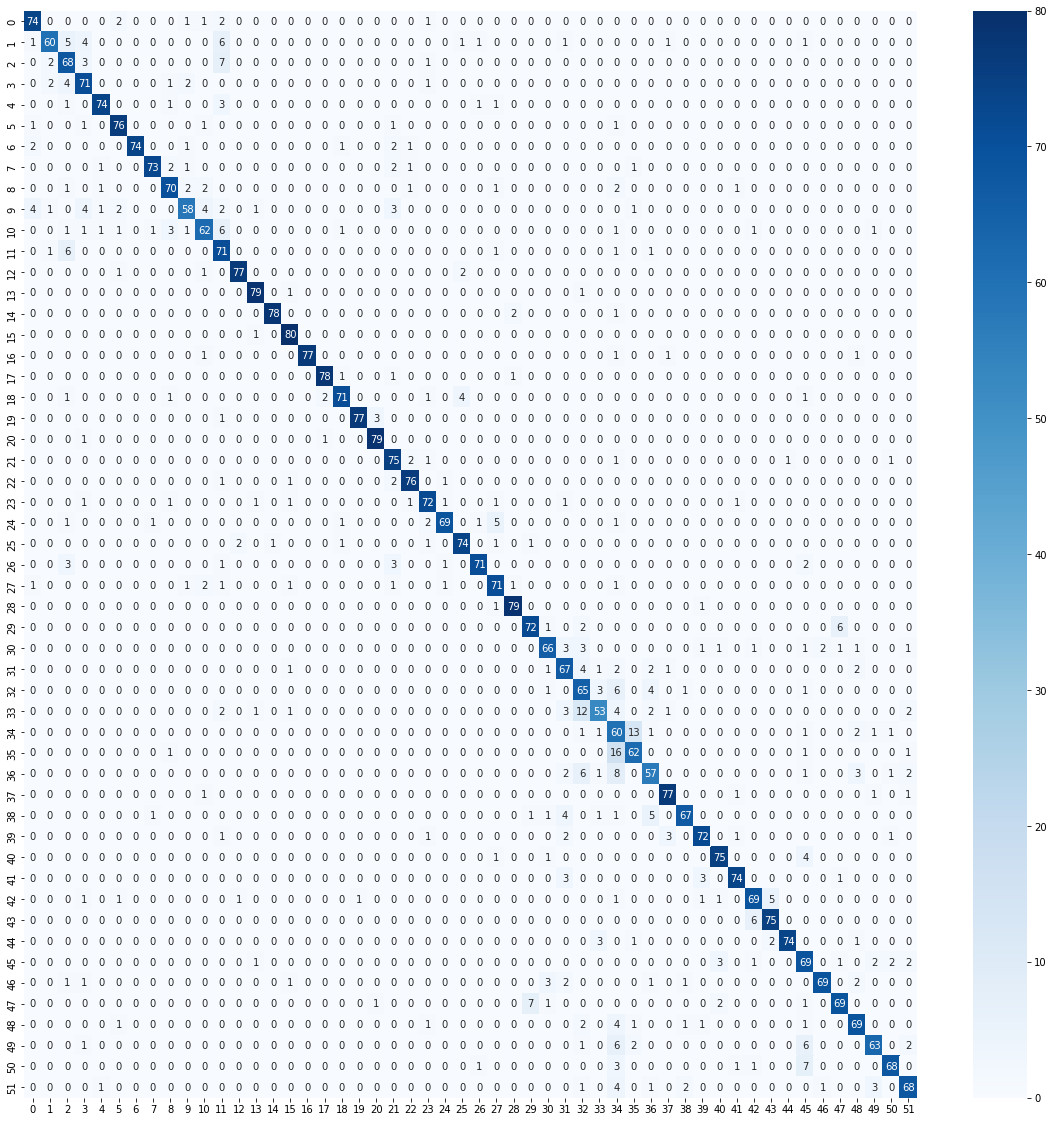

In [39]:
import seaborn as sns
import sklearn.metrics
plt.figure(figsize=(20,20))
sns.heatmap(sklearn.metrics.confusion_matrix(torch.argmax (y_test_comd.cpu(), 1).numpy() , np.argmax (pred_y_comd, 1)), annot=True,cmap='Blues')

In [40]:
for s in range(1,28):
    tensordata = Test_Inputs.permute(1,0,2,3,4)[test_participant_no==s]
    x_test_single = tensordata.to(device)
    y_test_comd_single = torch.from_numpy(Test_command_class[test_participant_no==s])
    pred_y_sub_single = []
    pred_y_comd_single = []
    for i in range(len(x_test_single)):
        pred_y_comd_single.append(best_model(x_test_single[i].view(-1,10,3,224,224))[1].cpu()[0].detach().numpy())
    comd_acc_single = np.sum(np.argmax (pred_y_comd_single, 1) == torch.argmax (y_test_comd_single.cpu(), 1).numpy() )/(len(pred_y_comd_single))
    print("Subject #",s,": test Command Accuracy:",np.round(comd_acc_single.item(),4))


Subject # 1 : test Command Accuracy: 0.8654
Subject # 2 : test Command Accuracy: 0.891
Subject # 3 : test Command Accuracy: 0.8141
Subject # 4 : test Command Accuracy: 0.8141
Subject # 5 : test Command Accuracy: 0.8333
Subject # 6 : test Command Accuracy: 0.8846
Subject # 7 : test Command Accuracy: 0.9231
Subject # 8 : test Command Accuracy: 0.9231
Subject # 9 : test Command Accuracy: 0.8974
Subject # 10 : test Command Accuracy: 0.8205
Subject # 11 : test Command Accuracy: 0.8526
Subject # 12 : test Command Accuracy: 0.891
Subject # 13 : test Command Accuracy: 0.8654
Subject # 14 : test Command Accuracy: 0.8974
Subject # 15 : test Command Accuracy: 0.8718
Subject # 16 : test Command Accuracy: 0.8718
Subject # 17 : test Command Accuracy: 0.9038
Subject # 18 : test Command Accuracy: 0.7564
Subject # 19 : test Command Accuracy: 0.891
Subject # 20 : test Command Accuracy: 0.891
Subject # 21 : test Command Accuracy: 0.9679
Subject # 22 : test Command Accuracy: 0.9167
Subject # 23 : test Com

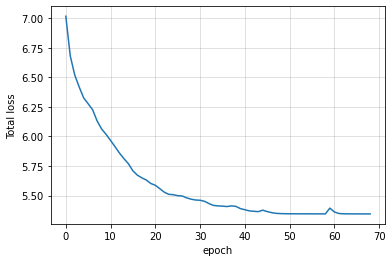

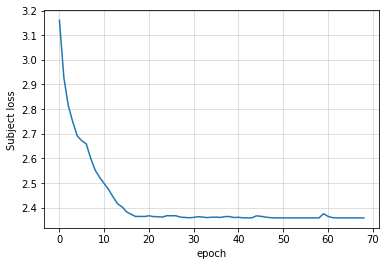

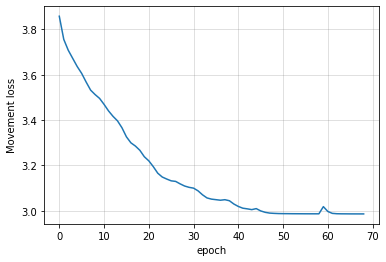

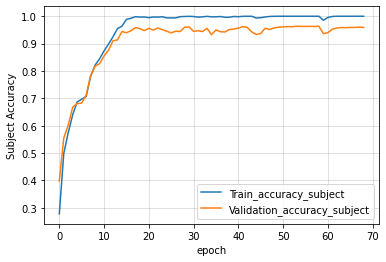

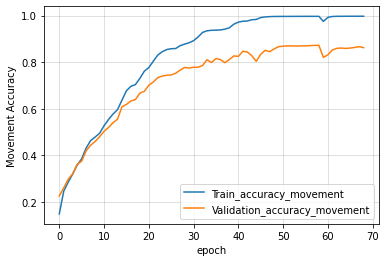

In [41]:
import matplotlib.pyplot as plt
plt.plot(best_loss_record['total'])
plt.ylabel('Total loss')
plt.xlabel('epoch')
plt.grid(color='gray', alpha=0.3)
plt.show()

plt.plot(best_loss_record['sub'])
plt.ylabel('Subject loss')
plt.xlabel('epoch')
plt.grid(color='gray', alpha=0.3)
plt.show()

plt.plot(best_loss_record['mov'])
plt.ylabel('Movement loss')
plt.grid(color='gray', alpha=0.3)
plt.xlabel('epoch')
plt.show()


plt.plot(best_loss_record['train_acc_sub'],label="Train_accuracy_subject")
plt.plot(best_loss_record['val_acc_sub'],label="Validation_accuracy_subject")
plt.ylabel('Subject Accuracy')
plt.xlabel('epoch')
plt.legend()
plt.grid(color='gray', alpha=0.3)
plt.show()

plt.plot(best_loss_record['train_acc_mov'],label="Train_accuracy_movement")
plt.plot(best_loss_record['val_acc_mov'],label="Validation_accuracy_movement")
plt.ylabel('Movement Accuracy')
plt.xlabel('epoch')
plt.legend()
plt.grid(color='gray', alpha=0.3)
plt.show()